In [47]:
import hashlib
import os
import tarfile
import zipfile
import requests

In [48]:
DATA_HUB=dict()
DATA_URL='http://d2l-data.s3-accelerate.amazonaws.com/'


In [49]:
def download(name,cache_dir=os.path.join('..','data')):
  assert name in DATA_HUB,f"{name}不存在于{DATA_HUB}"
  url,sha1_hash=DATA_HUB[name]
  os.makedirs(cache_dir,exist_ok=True)#创建目录cache_dir，exist_ok=True表明若目录已存在则跳过
  fname=os.path.join(cache_dir,url.split('/')[-1])#拼接路径
  if os.path.exists(fname):
    sha1=hashlib.sha1()#创建sha1哈希对象
    with open(fname,'rb') as f:
      while True:
        data=f.read(1048576)
        if not data:
          break
        sha1.update(data)#更新对象数据
    if sha1.hexdigest()==sha1_hash:#获取计算得到的哈希值的十六进制表示
      return fname
  print(f'正在从{url}下载{fname}...')
  r=requests.get(url,stream=True,verify=True)
  with open(fname,'wb') as f:
    f.write(r.content)
  return fname

In [50]:
def download_extract(name,folder=None):
  #下载并解压zip/tar文件
  fname=download(name)
  base_dir=os.path.dirname(fname)
  data_dir,ext=os.path.splitext(fname)
  #打开压缩文件
  if ext=='.zip':
    fp=zipfile.ZipFile(fname,'r')
  elif ext in ('.tar','.gz'):
    fp=tarfile.open(fname,'r')
  else:
    assert False
  fp.extractall(base_dir)#将压缩文件中的所有文件解压到指定目录
  return os.path.join(base_dir,folder) if folder else data_dir
def download_all():
  #下载DATA_HUB中的所有文件
  for name in DATA_HUB:
    download(name)

#1.下载数据

In [51]:
%matplotlib inline
import numpy as np
import pandas as pd
import torch
from torch import nn
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import norm
from scipy import stats

In [52]:
DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

In [53]:
train_data=pd.read_csv(download('kaggle_house_train'))
test_data=pd.read_csv(download('kaggle_house_test'))

###数据可视化

<ipython-input-54-6af6ae6d5957>:4: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  abs(train_data.corr()['SalePrice']).sort_values(ascending=False).plot.bar()


(array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2]),
 [Text(0, 0.0, '0.0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6000000000000001, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0'),
  Text(0, 1.2000000000000002, '1.2')])

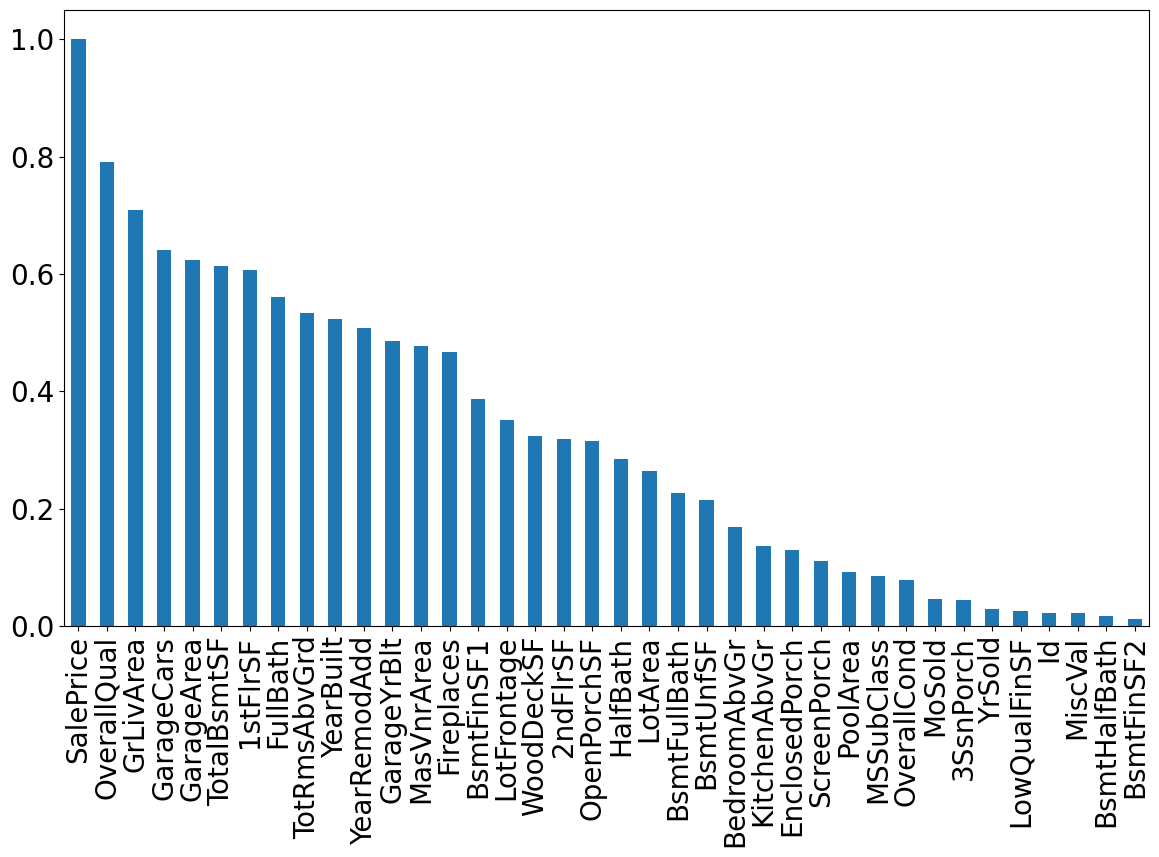

In [54]:
fig=plt.figure(figsize=(14,8))
#从相关系数矩阵中选择因变量SalePrice与自变量之间的相关性列，对相关性的绝对值大小降序排列
#获取的是相关性绝对值，相关性接近0表示无相关性，该处获取的是线性相关性
abs(train_data.corr()['SalePrice']).sort_values(ascending=False).plot.bar()
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

In [55]:
print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [56]:
print(train_data.iloc[0:4,[0,1,2,3,-3,-2,-1]])#显示0~3行，0~3和倒数第三到第一列
print(test_data.iloc[0:4,[0,1,2,3,-3,-2,-1]])#待预测数据集中没有价格这一列

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000
     Id  MSSubClass MSZoning  LotFrontage  YrSold SaleType SaleCondition
0  1461          20       RH         80.0    2010       WD        Normal
1  1462          20       RL         81.0    2010       WD        Normal
2  1463          60       RL         74.0    2010       WD        Normal
3  1464          60       RL         78.0    2010       WD        Normal


#2.数据预处理


<Figure size 640x480 with 0 Axes>

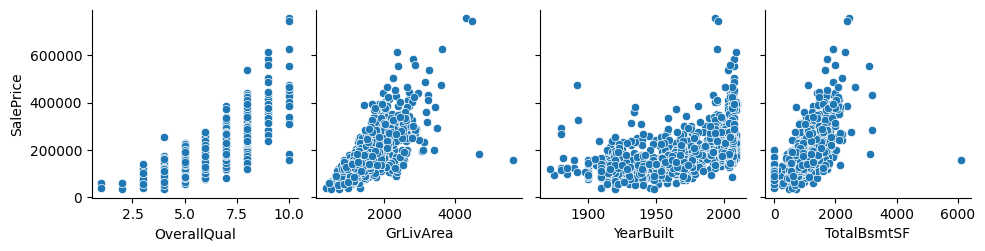

In [57]:
figure=plt.figure()
sns.pairplot(x_vars=['OverallQual','GrLivArea','YearBuilt','TotalBsmtSF'],
       y_vars=['SalePrice'],data=train_data,dropna=True)
plt.show()

可以观察到如下信息：
* OverallQual：总体质量评分小于5，销售价格却大于200000
* GrLivArea：居住面积大于4000，销售价格却小于300000，根据我们的常识可以得知，一般来说居住面积越大，销售价格应该越高。
* YearBuilt:建造年份在1900年之前的销售价格还大于400000
* TotalBsmtSF：地下室总面积大于6000，销售价格还低于200000.  
综合上述分析，我们删除这些异常值


In [58]:
train_data=train_data.drop(train_data[(train_data['OverallQual']<5)&(train_data['SalePrice']>200000)].index)
train_data=train_data.drop(train_data[(train_data['GrLivArea']>4000)&(train_data['SalePrice']<300000)].index)
train_data=train_data.drop(train_data[(train_data['YearBuilt']<1900)&(train_data['SalePrice']>400000)].index)
train_data=train_data.drop(train_data[(train_data['TotalBsmtSF']>6000)&(train_data['SalePrice']<200000)].index)

<Figure size 640x480 with 0 Axes>

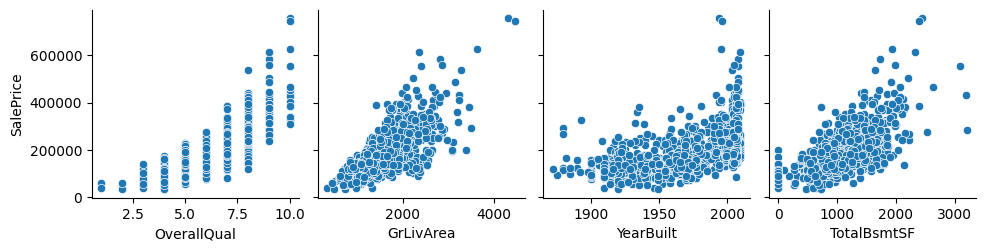

In [59]:
figure=plt.figure()
sns.pairplot(x_vars=['OverallQual','GrLivArea','YearBuilt','TotalBsmtSF'],
       y_vars=['SalePrice'],data=train_data,dropna=True)
plt.show()

检查发现异常数据已经处理掉了

In [60]:
#第一个特征是ID，无效特征删除
#拼接特征，训练集需要把最后一列价格去掉
all_features=pd.concat((train_data.iloc[:,1:-1],test_data.iloc[:,1:]))
all_features.shape

(2915, 79)

**1**.把缺失值替换为相应特征的均值  
**2**.均值归一化

In [61]:
all_features.dtypes

MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
                  ...   
MiscVal            int64
MoSold             int64
YrSold             int64
SaleType          object
SaleCondition     object
Length: 79, dtype: object

In [62]:
#选出数值类型的特征列并获取其索引
numeric_features=all_features.dtypes[all_features.dtypes!='object'].index
#对数值类型的特征进行归一化处理
all_features[numeric_features]=all_features[numeric_features].apply(
    lambda x:(x-x.mean())/(x.std())#对数值特征的列进行处理
)
#填充缺失值为0,因为数值特征均值归一化后均值就是0
all_features[numeric_features]=all_features[numeric_features].fillna(0)

In [63]:
all_features[numeric_features]

,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
0,0.067175,-0.183043,-0.215097,0.650801,-0.506891,1.046889,0.897604,0.527555,0.601388,-0.293248,...,0.352944,-0.739813,0.206306,-0.359818,-0.103384,-0.286013,-0.060458,-0.089639,-1.553342,0.157006
1,-0.873119,0.475068,-0.067000,-0.061051,2.191079,0.154623,-0.394384,-0.570164,1.213886,-0.293248,...,-0.057152,1.615152,-0.704066,-0.359818,-0.103384,-0.286013,-0.060458,-0.089639,-0.447695,-0.603246
2,0.067175,-0.051421,0.145488,0.650801,-0.506891,0.980795,0.849753,0.337135,0.105985,-0.293248,...,0.632555,-0.739813,-0.077252,-0.359818,-0.103384,-0.286013,-0.060458,-0.089639,1.026500,0.157006
3,0.302249,-0.402414,-0.073439,0.650801,-0.506891,-1.861236,-0.681493,-0.570164,-0.502009,-0.293248,...,0.791001,-0.739813,-0.181721,3.871497,-0.103384,-0.286013,-0.060458,-0.089639,-1.553342,-1.363497
4,0.067175,0.650564,0.533116,1.362653,-0.506891,0.947748,0.754050,1.390049,0.486544,-0.293248,...,1.695077,0.777480,0.549561,-0.359818,-0.103384,-0.286013,-0.060458,-0.089639,2.132147,0.157006
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2.417911,-2.113504,-1.053971,-1.484755,1.291756,-0.043658,-0.681493,-0.570164,-0.988404,-0.293248,...,-2.200836,-0.739813,-0.704066,-0.359818,-0.103384,-0.286013,-0.060458,-0.089639,-0.079146,-1.363497
1455,2.417911,-2.113504,-1.059380,-1.484755,-0.506891,-0.043658,-0.681493,-0.570164,-0.420943,-0.293248,...,-0.868024,-0.739813,-0.345887,-0.359818,-0.103384,-0.286013,-0.060458,-0.089639,-0.816244,-1.363497
1456,-0.873119,3.984995,1.272314,-0.772903,1.291756,-0.374127,0.562644,-0.570164,1.767836,-0.293248,...,0.483429,3.006004,-0.704066,-0.359818,-0.103384,-0.286013,-0.060458,-0.089639,1.026500,-1.363497
1457,0.654859,-0.314666,0.041305,-0.772903,-0.506891,0.683373,0.371238,-0.570164,-0.229538,-0.293248,...,-2.200836,-0.107608,-0.226494,-0.359818,-0.103384,-0.286013,-0.060458,1.143215,0.289402,-1.363497


In [64]:
#处理离散值，使用独热编码
all_features=pd.get_dummies(all_features,dummy_na=True)#dummy_na=True将原数据中的缺失值也当作一种特征值来编码
all_features.shape

(2915, 330)

In [65]:
n_train=train_data.shape[0]
train_features=torch.tensor(all_features[:n_train].values,dtype=torch.float32)
test_features=torch.tensor(all_features[n_train:].values,dtype=torch.float32)
train_labels=torch.tensor(train_data.SalePrice.values.reshape(-1,1),dtype=torch.float32)

In [66]:
train_labels

tensor([[208500.],
        [181500.],
        [223500.],
        ...,
        [266500.],
        [142125.],
        [147500.]])

In [67]:
train_data.SalePrice

0       208500
1       181500
2       223500
3       140000
4       250000
         ...  
1455    175000
1456    210000
1457    266500
1458    142125
1459    147500
Name: SalePrice, Length: 1456, dtype: int64

#3.训练
以线性模型作为baseline

In [68]:
train_features.shape

torch.Size([1456, 330])

In [125]:
loss=nn.MSELoss()
in_features=train_features.shape[1]
def get_net():
  #调整网络结构
  net=nn.Sequential(
      nn.Linear(in_features,256),
      nn.ReLU(),
      nn.Linear(256,1)
      )
  #参数初始化
  for param in net.parameters():
    nn.init.normal_(param,mean=0,std=0.01)
  return net

In [118]:
def log_rmse(net,features,labels):
  #torch.clamp将预测值限制在1到正无穷范围内，若小于1则取1，避免取对数时负无穷的情况
  clipped_preds=torch.clamp(net(features),1,float('inf'))
  rmse=torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))
  return rmse.item()#item()方法返回标量

In [119]:
from torch.utils import data
#构造一个Pytorch数据迭代器
def load_array(data_arrays,batch_size,is_train=True):
  dataset=data.TensorDataset(*data_arrays)#'*'用于解包可迭代对象，相当于向函数内传入解包后的元素作为参数
  return data.DataLoader(dataset,batch_size,shuffle=is_train)

def train(net,train_features,train_labels,test_features,test_labels,num_epochs,learning_rate,weight_decay,batch_size):
  train_ls,test_ls=[],[]
  train_iter=load_array((train_features,train_labels),batch_size)
  optimizer=torch.optim.Adam(net.parameters(),lr=learning_rate,weight_decay=weight_decay)
  for epoch in range(num_epochs):#开始迭代
    for X,y in train_iter:#对当前迭代中的每一批训练数据
      optimizer.zero_grad()#清空梯度
      l=loss(net(X),y)#计算均方误差损失
      l.backward()#反向传播
      optimizer.step()#更新权重
    train_ls.append(log_rmse(net,train_features,train_labels))#完成一次迭代，记录一次训练集对数损失
    if test_labels is not None:#用于K折交叉验证时计算验证集的损失
      test_ls.append(log_rmse(net,test_features,test_labels))
  return train_ls,test_ls

#4.K折交叉验证

In [120]:
#把训练数据划分为k份，取第i份作为验证集，返回训练集和验证集
def get_k_fold_data(k,i,X,y):
  assert k>1
  fold_size=X.shape[0]//k
  X_train,y_train=None,None
  for j in range(k):
    idx=slice(j*fold_size,(j+1)*fold_size)#生成一个切片对象，即要截取的子集的行索引
    X_part,y_part=X[idx,:],y[idx]
    if j==i:#若当前子集索引j等于i，即把其作为验证集
      X_valid,y_valid=X_part,y_part
    elif X_train is None:#若当前训练集为空，则把子集赋给训练集
      X_train,y_train=X_part,y_part
    else:#训练集不为空，把新的子集拼接到训练集上，按第0维度拼接
      X_train=torch.cat([X_train,X_part],0)
      y_train=torch.cat([y_train,y_part],0)
  return X_train,y_train,X_valid,y_valid

In [121]:
#实现K折交叉验证
def k_fold(k,X_train,y_train,num_epochs,learning_rate,weight_decay,batch_size):
  train_l_sum,valid_l_sum=0,0
  for i in range(k):
    data=get_k_fold_data(k,i,X_train,y_train)
    net=get_net()
    train_ls,valid_ls=train(net,*data,num_epochs,learning_rate,weight_decay,batch_size)
    train_l_sum+=train_ls[-1]
    valid_l_sum+=valid_ls[-1]
    print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
  return train_l_sum/k,valid_l_sum/k

#5.模型选择
当有了足够大的数据集和合理设置的超参数，K折交叉验证往往对多次测试结果具有相当的稳定性；  
当训练误差显著低于测试误差时，表明模型可能过拟合了，这时需要进行适当的正则化技术来处理

In [127]:
#超参数设置
k=8
weight_decay=300
lr=0.03
num_epoch=150
batch_size=32
train_l,valid_l=k_fold(k,train_features,train_labels,num_epoch,lr,weight_decay,batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
        f'平均验证log rmse: {float(valid_l):f}')

折1，训练log rmse0.091416, 验证log rmse0.129568
折2，训练log rmse0.087324, 验证log rmse0.104771
折3，训练log rmse0.083597, 验证log rmse0.140105
折4，训练log rmse0.085031, 验证log rmse0.137882
折5，训练log rmse0.089956, 验证log rmse0.097663
折6，训练log rmse0.088068, 验证log rmse0.127864
折7，训练log rmse0.089534, 验证log rmse0.084708
折8，训练log rmse0.087442, 验证log rmse0.116116
8-折验证: 平均训练log rmse: 0.087796, 平均验证log rmse: 0.117334


#6.模型预测
在确认超参数后，使用全部训练数据进行训练，预测测试集的标签

In [128]:
def train_and_pred(train_features,test_features,train_labels,test_data,num_epochs,lr,weight_decay,batch_size):
  net=get_net()
  train_ls,_=train(net,train_features,train_labels,None,None,num_epochs,lr,weight_decay,batch_size)
  print(f"训练log rmse:{float(train_ls[-1]):f}")
  preds=net(test_features).detach().numpy()#detach将创建一个与计算图不关联的数据
  test_data['SalePrice']=pd.Series(preds.reshape(1,-1)[0])#把预测结果转化为行向量，再转化为Series对象
  submission=pd.concat([test_data['Id'],test_data['SalePrice']],axis=1)#给结果添加上对应Id
  submission.to_csv('submission.csv',index=False)#index=False表示不保存索引列到文件中，只保存数据列

In [129]:
train_and_pred(train_features,test_features,train_labels,test_data,num_epoch,lr,weight_decay,batch_size)

训练log rmse:0.085830
